In [42]:
#@title Imports and Notebook Utilities

# System imports

import sys
import os
import io
import re
import PIL.Image, PIL.ImageDraw
import base64
import zipfile
import json
import requests
import numpy as np
import matplotlib.pylab as pl
import matplotlib.pyplot as plt
import glob

import tensorflow as tf

from IPython.display import Image, HTML, clear_output
import tqdm

import os
os.environ['FFMPEG_BINARY'] = 'ffmpeg'
import moviepy.editor as mvp
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter
clear_output()


In [43]:
print(os.getcwd())
os.chdir('caproject')
print(os.getcwd())
!ls

/u/sradev/deep-learning-project/caproject


FileNotFoundError: [Errno 2] No such file or directory: 'caproject'

In [44]:
# Module imports

import importlib
import caproject.model, image_processing, utils, figures, train
from experiments import Experiments

def force_import(module: str):
    importlib.reload(sys.modules[module])
    

In [45]:
force_import('model')
force_import('utils')
force_import('experiments')
force_import('train')
import model, train, experiments


...........................IN model.py...........................

...........................IN utils.py...........................

...........................IN train.py...........................


In [367]:
CHANNEL_N = 16
HIDDEN_SIZE = 128
TARGET_SIZE = 48
EXPERIMENT_TYPE = "persistent"

# Define some common-use image name-target pairs
br, sn, s, m1, m = 'bob-ross-painting', 'starry-night', 'sleigh', 'mozart1', 'mozart'

IMAGE_TARGET_MAP = {'bob-ross-painting': 135, 'starry-night': 150, 'sleigh': 48, 
                    'mozart1': 48, 'mozart': 48}

def get_hidden_size_name(hidden_size):
    hidden_size_name = hidden_size
    if type(hidden_size) == list:
        hidden_size_name = '-'.join(str(e) for e in hidden_size)
    elif hidden_size is None:
        return None
    elif type(hidden_size) != int:
        sys.exit("get_hidden_size_name: Hidden size must be either int or list")
    return hidden_size_name

def get_models(image_name, target_size, channel_n=None, hidden_size=None, experiment_type=EXPERIMENT_TYPE):
    """Given an image name and its target size, locate the directory and return a list of all models.
       If channel_n or hidden_size specified, return only those models.
    """
    
    channels = []
    hidden_sizes = []
    path = f'figures/{image_name}-{target_size}/{experiment_type}/'
    for model in os.listdir(path):
        model_name_lst = re.split("[-|_]", model)
        try: 
            assert model_name_lst[0] == 'channel' and model_name_lst[2] == 'hidden'
        except (ValueError, AssertionError):
            continue
        channels.append(int(model_name_lst[1]))
        if len(model_name_lst[3:]) == 1: hidden_sizes.append(int(model_name_lst[3]))
        else: hidden_sizes.append([int(n) for n in model_name_lst[3:]])
        
    return channels, hidden_sizes

def get_dir(image_name, channel_n=None, hidden_size=None, target_size=None, 
            experiment_type=EXPERIMENT_TYPE, plot_loss=True, figsize=(10, 4)):
    """Given an image name, iterates""" 
    
    if not target_size:
        target_size = IMAGE_TARGET_MAP[image_name]
    path = f'figures/{image_name}-{target_size}/{experiment_type}/'    
            
    # Get all channels and hidden sizes for requested image name and target size
    channels, hidden_sizes = get_models(image_name, target_size, channel_n, hidden_size)
    models = os.listdir(path)
    model_indices = []        
    
    # Handle the different cases
    hidden_size_name = get_hidden_size_name(hidden_size)
    if channel_n and not hidden_size:
        model_indices = list(np.where(np.array(channels) == channel_n)[0])
    elif hidden_size and not channel_n:
        print(models)
        print(hidden_size)
        print(np.array(hidden_sizes))
        model_indices = list(np.where(np.array(hidden_sizes) == hidden_size)[0])
        print(model_indices)
    elif channel_n and hidden_size:
        model_indices.append(models.index(f'channel-{channel_n}_hidden-{hidden_size_name}'))
    else:
        model_indices = [i for i in range(len(models))]

    if model_indices == []:
        print('Could not find any experiments with those credentials')
        return None, []
        
    ## Initialize the figure
    # https://stackoverflow.com/questions/12319796/dynamically-add-create-subplots-in-matplotlib
    n_subplots = len(model_indices)+1
    cols = n_subplots if n_subplots < 3 else 3
    rows = n_subplots // cols
    if n_subplots % cols != 0:
        rows += 1  
    position = range(1, n_subplots+1)
    
    cmap = plt.get_cmap('tab10')
    fig = plt.figure(figsize=(6.4*cols, 4.8*rows)) 
    if len(model_indices) > 1: ax0 = fig.add_subplot(rows, cols, position[0])
        
    loss_logs = []        
    for i, model_index in enumerate(model_indices):
        channel_n = channels[model_index]
        hidden_size = hidden_sizes[model_index]

        hidden_size_name = get_hidden_size_name(hidden_sizes[model_index])
        tmp = path + f'channel-{channels[model_index]}_hidden-{hidden_size_name}/'        
        try:
            tmp = path + f'channel-{channels[model_index]}_hidden-{hidden_size_name}/'
            loss_log = np.load(tmp+'loss_log.npy')        
        except FileNotFoundError:
            print(f"WARNING: File loss_log.npy not found in folder {tmp}")
        
        if len(model_indices) > 1: 
            # Plot on the main axis
            ax0.set_title(f'Loss (log10) for {image_name}.png with {target_size} target size')
            ax0.plot(np.log10(loss_log), '.', alpha=0.1, color=cmap(i), label=f'{channel_n} Channels, {hidden_size} Hidden Size')
        
        # Plot the individual loss
        ax = fig.add_subplot(rows, cols, position[i+1])
        # ax.set_title(f'Loss (log10) for {image_name}.png with {target_size} target size')
        ax.plot(np.log10(loss_log), '.', alpha=0.1, color=cmap(i), label=f'{channel_n} Channels, {hidden_size} Hidden Size')
        ax.set_ylim(top=-0.5)
        if len(model_indices) > 1: ax.sharey(ax0)
        ax.legend()
        
        loss_logs.append(loss_log)

    if len(model_indices) > 1: 
        ax0.set_ylim(top=-0.5)
        ax0.legend()

    # fig.legend()
    fig.tight_layout()
    
    fig.show()
    
    return path, loss_logs
    

In [369]:
mozart_dir, loss_logs1 = get_dir(sn, 12)
# print(mozart_dir, loss_log)

Could not find any experiments with those credentials


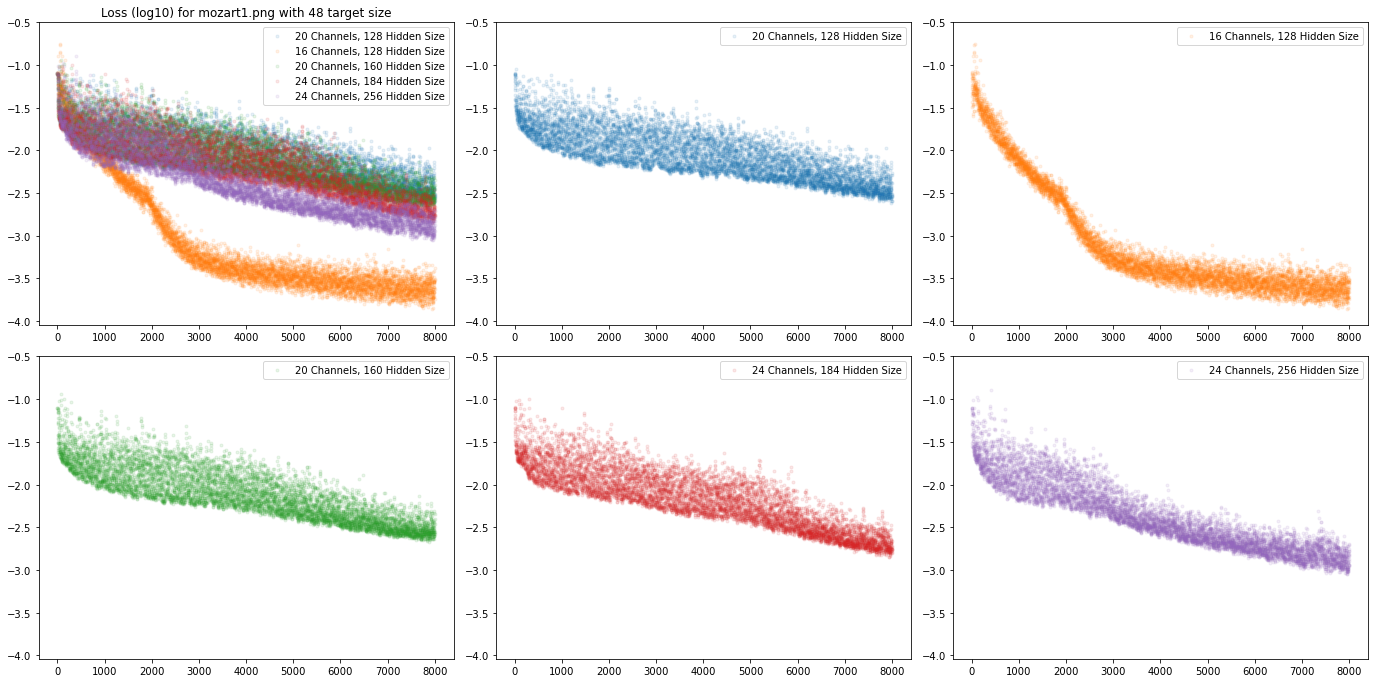

In [363]:
mozart_dir, loss_logs1 = get_dir(m1, figsize=(15, 10))
# print(mozart_dir, loss_log)

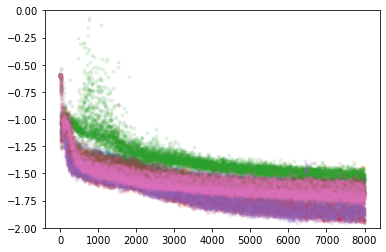

In [432]:
for loss_log in loss_logs:
    plt.plot(np.log10(loss_log), '.', alpha=0.1)
    plt.ylim(top=0, bottom=-2)
    
# plt.plot(loss_logs[0], '.')
# plt.ylim(top=0, bottom=-2)

figures/bob-ross-painting-135/persistent/
figures/bob-ross-painting-135/persistent/ [array([0.18419454, 0.18428871, 0.18383944, ..., 0.14217858, 0.07782964,
       0.12021103], dtype=float32)]


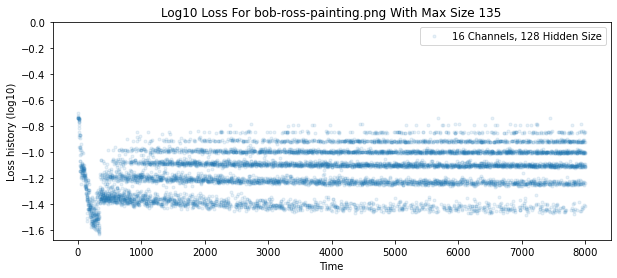

In [252]:
mozart_dir, loss_log = get_dir(br, channel_n=CHANNEL_N, hidden_size=HIDDEN_SIZE)
print(mozart_dir, loss_log)

In [344]:
def get_experiment_data(experiment_n, image_name, channel_n, hidden_size):
    target_size = IMAGE_TARGET_MAP[image_name]
    
    hidden_size_name = get_hidden_size_name(hidden_size)
    path = f'figures/experiments/experiment{experiment_n}/{image_name}-{target_size}/channel-{channel_n}_hidden-{hidden_size_name}/'
    
    is_fire_rate = False
    
    res = {}

    for el in os.listdir(path):
        splitted_el = re.split('[-]', el)
        # print(splitted_el)
        if splitted_el[0] == 'fire_rate': 
            is_fire_rate = True
            fire_rate = splitted_el[1]
            loss_log = np.load(path + el + '/loss_log.npy')
            res[fire_rate] = np.log10(loss_log)
        # print('Returned loss_logs for fire_rate experiment')
        if splitted_el[0] == 'step_size': 
            is_fire_rate = False
            step_size = splitted_el[1]
            loss_log = np.load(path + el + '/loss_log.npy')
            res[step_size] = np.log10(loss_log)
        # print('Returned loss_logs for fire_rate experiment')
            
    if is_fire_rate:
        print('Returned loss_logs for fire_rate experiment')
    else:
        print('Returned loss_logs for step_size experiment')
            
    return res, path
    
    

In [355]:
ss_sleigh, path = get_experiment_data(4, s, 20, 160)
ss_sleigh
fr_sleigh, path = get_experiment_data(3, s, 20, 160)

Returned loss_logs for step_size experiment
Returned loss_logs for fire_rate experiment


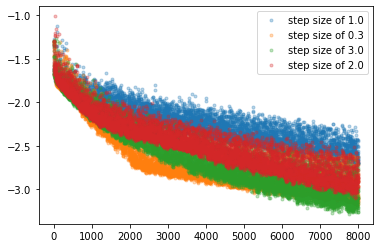

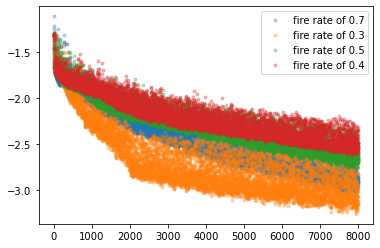

In [360]:
alpha = 0.3

for loss_log in ss_sleigh:
    plt.plot(ss_sleigh[loss_log], '.', alpha=alpha, label=f'step size of {loss_log}')

plt.legend()
# plt.savefig(f'{path}loss_plot-fire_rate.png')

plt.show()

for loss_log in fr_sleigh:
    plt.plot(fr_sleigh[loss_log], '.', alpha=alpha, label=f'fire rate of {loss_log}')

plt.legend()
# plt.savefig(f'{path}loss_plot-fire_rate.png')

plt.show()


Returned loss_logs for fire_rate experiment


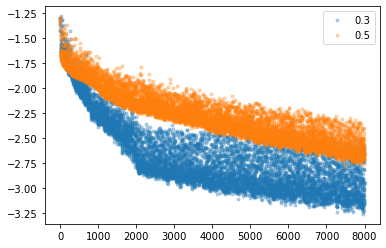

In [336]:
loss_logs = get_experiment_data(3, s, 20, 160)
loss_logs
plt.plot(loss_logs['0.3'], '.', alpha=0.3, label='0.3')
plt.plot(loss_logs['0.5'], '.', alpha=0.3, label='0.5')
plt.legend()
plt.show()

Returned loss_logs for fire_rate experiment


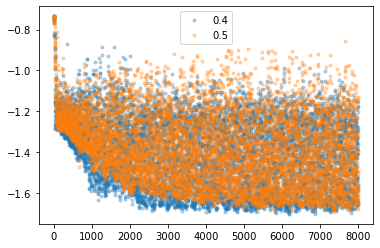

In [333]:
loss_logs = get_experiment_data(3, br, 12, 100)
plt.plot(loss_logs['0.4'], '.', alpha=0.3, label='0.4')
plt.plot(loss_logs['0.5'], '.', alpha=0.3, label='0.5')
plt.legend()
plt.show()

In [295]:
step_size_loss = get_experiment_data(4, br, 20, 256)
step_size_loss

Returned loss_logs for step_size experiment


{'1.0': array([-0.73472327, -0.7348206 , -0.7351882 , ..., -1.1819671 ,
        -1.1387563 , -1.6911321 ], dtype=float32),
 '0.3': array([-0.73472327, -0.7348138 , -0.7350315 , ..., -1.289757  ,
        -1.7831405 , -1.373602  ], dtype=float32),
 '3.0': array([-0.73472327, -0.7337282 , -0.73582256, ..., -1.7376037 ,
        -1.6923203 , -1.7353696 ], dtype=float32),
 '2.0': array([-0.73472327, -0.7343892 , -0.73542196, ..., -1.2106564 ,
        -1.2911526 , -1.6842358 ], dtype=float32)}

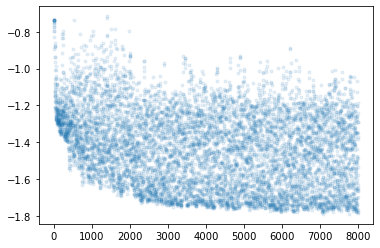

In [302]:
plt.plot(step_size_loss['0.3'], '.', alpha=0.1)


Running experiment 3 using image bob-ross-painting.png with target size of 135
USING FIRE RATE OF 0.4
USING FIRE RATE OF 0.4
Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_42 (Conv2D)          (1, 3, 3, 100)            3700      
                                                                 
 conv2d_43 (Conv2D)          (1, 3, 3, 12)             1212      
                                                                 
Total params: 4,912
Trainable params: 4,912
Non-trainable params: 0
_________________________________________________________________
Fire Rate = 0.4
Model already trained at figures/experiments/experiment3/bob-ross-painting-135/channel-12_hidden-100/fire_rate-0.4
USING FIRE RATE OF 0.5
USING FIRE RATE OF 0.5
Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              

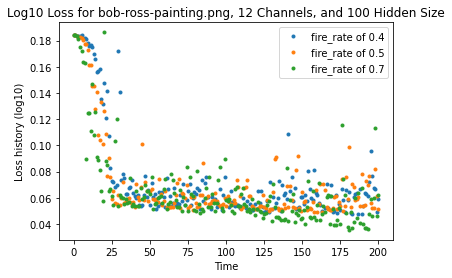

In [41]:
LIVING_MAP = {"bob-ross-painting":1, "starry-night":1, 
              "mozart1":0, "sleigh":0, "ca-pyramid":0,
              "mozart":1}

# Run experiments from experiments module
experiments = Experiments(EXPERIMENT_TYPE, CELL_FIRE_RATE, STEP_SIZE, 
        HIDDEN_SIZE, CHANNEL_N, TARGET_PADDING, BATCH_SIZE, POOL_SIZE, 
        USE_PATTERN_POOL, DAMAGE_N, THRESHOLD, LIVING_MAP, n_steps, MAKE_POOL)
image_name = 'bob-ross-painting'
target_size = 135
channel_n, hidden_size = 12, 100
cell_fire_rates = [0.4, 0.5, 0.7]

experiments.experiment3(image_name=image_name, target_size=target_size, channel_n=channel_n, 
                        hidden_size=hidden_size, cell_fire_rates=cell_fire_rates)